In [7]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import vectorbt as vbt
import pandas as pd

from datetime import datetime
from terminal.Extensions.MT5Helper import MT5
from terminal.Extensions.Range import Range
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

In [8]:
mt5.initialize()

True

In [9]:
brick_size = 0.05
slippage = 0.01

from_date = datetime(2024, 6, 3, tzinfo=pytz.utc)
to_date = datetime(from_date.year, 6, 3, 23, 59, 59, 0, tzinfo=pytz.utc)

data = mt5.copy_ticks_range("WIN$", from_date, to_date, mt5.COPY_TICKS_TRADE)
rates = MT5.OHLC(data, "10s")

rates.index = rates.index.tz_localize(None)
rates.dropna(inplace=True)

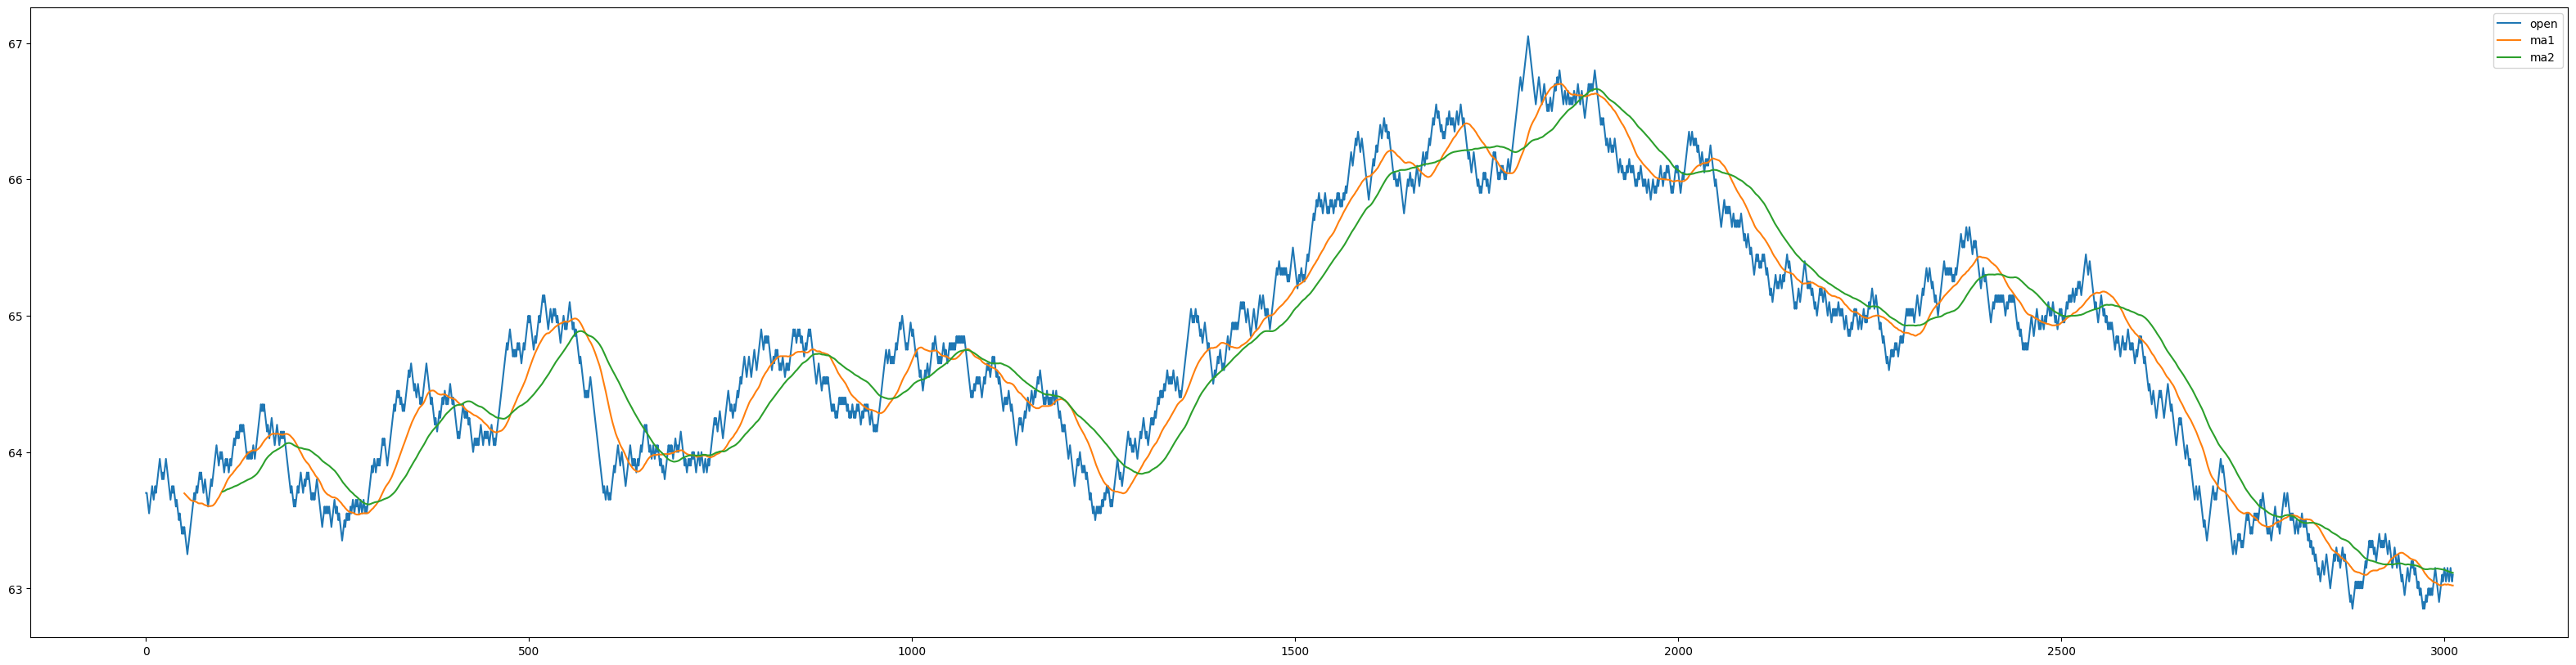

In [183]:
range = Range(brick_size=brick_size, times=rates.index.values, prices=rates["open"])
range_oc = pd.DataFrame(range.bricks)

range_oc["ma1"] = range_oc["close"].shift(1).rolling(50).mean()
range_oc["ma2"] = range_oc["close"].shift(1).rolling(100).mean()
range_oc["entry"] = 0
range_oc["exit"] = 0

range_oc.loc[range_oc["ma1"] > range_oc["ma2"], "entry"] = 1
range_oc.loc[range_oc["ma1"] < range_oc["ma2"], "entry"] = -1
#range_oc.loc[range_oc["ma1"] < range_oc["ma2"], "exit"] = 1

range_oc.iloc[:][["open", "ma1", "ma2"]].plot(figsize=(40, 10))
range_oc.to_excel("output.xlsx")

<Axes: >

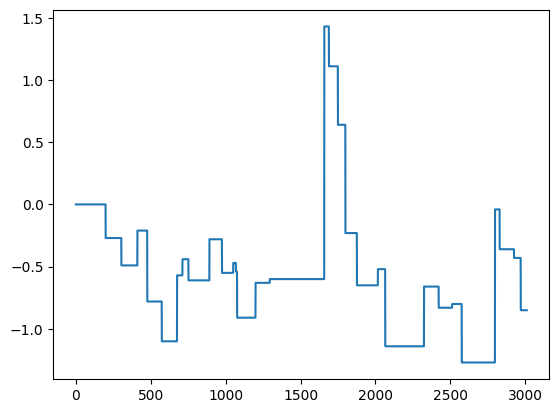

In [184]:
range_oc["buyPrice"] = np.nan
range_oc["sellPrice"] = np.nan
range_oc["tradeProfit"] = 0
range_oc["profit"] = 0

position = 0

for i, item in range_oc.iterrows():
    if position == 0:
        if item.entry == 1:
            range_oc.loc[i, "buyPrice"] = buyPrice = item.open + slippage
            position = 1
        elif item.entry == -1:
            range_oc.loc[i, "sellPrice"] = sellPrice = item.open - slippage
            position = -1

    if position == 1:
        if item.exit or item.entry == -1:
            range_oc.loc[i, "sellPrice"] = sellPrice = item.open - slippage
            range_oc.loc[i, "tradeProfit"] = sellPrice - buyPrice
            position = 0

    if position == -1:
        if item.exit or item.entry == 1:
            range_oc.loc[i, "buyPrice"] = buyPrice = item.open + slippage
            range_oc.loc[i, "tradeProfit"] = sellPrice - buyPrice
            position = 0

range_oc["profit"] = range_oc["tradeProfit"].cumsum()
range_oc.to_excel("output_result.xlsx")

range_oc["profit"].plot()